# Feature Importance in COVID-19
** On controlling spread of infections in countries **

COVID-19, since its outbreak in Wuhan, China, has spread all over the world. Australia is also affected badly. To control the spread of infection, to save lives and livelihood, different countries 
have imposed different measures. Here we have created a feature vector based on the measures imposed on a country at different point of time with respect to the first case recorded. Our focus is on 
the countries that have the number of confirmed cases more than Australia. 


In [17]:
## All datasets are sourced from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
## The followings libraries/packages are needed for data analysis, processing, regression modelling
## and plotting

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from adjustText import adjust_text # use "conda install -c primer adjusttext" from Ananconda prompt
import re # for regular expressions

from scipy.signal import find_peaks #used to find peaks and valleys in curves
from sklearn import preprocessing 

from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb # Install with Anaconda: "conda install xgboost"
from sklearn.model_selection import train_test_split#, cross_val_score, KFold
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error #mean_squared_error#, , r2_score
%matplotlib inline

## ************************** Confirmed cases  *******************************
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/\
csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_confirmed = pd.read_csv(url_confirmed, index_col="Country/Region")
df_confirmed.drop(['Lat', 'Long'], axis=1, inplace=True) # We are not interested in these two columns

# The size of our data set is small and modelling parameters are sensitive to data. 
# With time the number of countries having number of cases more than Australia is growing,
# and thus affecting the model output. 
# To compare with the results with 28thAug scenario we need to discard data after 28thAug.
# Discard the following 3 lines if one wants to work with the latest data 

cols_del = len(df_confirmed.columns) - ((df_confirmed.columns).get_loc('8/28/20'))-1
print(len(df_confirmed.columns), (df_confirmed.columns).get_loc('8/28/20'), cols_del)
df_confirmed.drop(df_confirmed.columns[-cols_del:], axis=1, inplace=True) 

# Country grouping on original dataframe        
gr_confirmed = df_confirmed.groupby("Country/Region").sum()

# Adding data for China (1-Jan to 20-Jan from a China CDC publication)
lab=[]
for i in range(1,22):
    lab.append("1/" + str(i) + "/20")
    gr_confirmed.insert(i-1,lab[i-1],0)
gr_confirmed.loc["China"][0:10] = 20
gr_confirmed.loc["China"][10:21] = 310

# Remove Diamond princess as we do not want to include that data for our analysis
gr_confirmed = gr_confirmed.drop("Diamond Princess")

#Dates are converted into no of days since 1/1/20 so that 1/1/20 corresponds to day 1
dates = gr_confirmed.keys()
date_1st_case = gr_confirmed.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
FMT = '%m/%d/%y'
days = dates.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("1/1/20", FMT)).days) 
gr_confirmed.columns = days
x = gr_confirmed.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
x_aust = gr_confirmed.loc["Australia"].ne(0).idxmax(axis=1) #x_aust: position of 1st case for Aust

# Subset of countries having cases reported earlier than Australia (i.e cases reported before 26Jan) 
gr_confirmed_sub = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if (x[i] <= x_aust) and (gr_confirmed.iloc[i].max() != 0) and\
        not(re.search('Australia_', gr_confirmed.index[i])):
       gr_confirmed_sub = gr_confirmed_sub.append(gr_confirmed.loc[gr_confirmed.index[i]]) 
   
x_sub = gr_confirmed_sub.ne(0).idxmax(axis=1) # x_sub gives position of first non-zero value in each row
for i in range(gr_confirmed_sub.shape[0]):
    gr_confirmed_sub.iloc[i] = gr_confirmed_sub.iloc[i].shift(periods=-x_sub[i]) # data starts from day when a first case is reported
gr_confirmed_sub.columns = dates

# ******** Subset of countries having no. of cases more than Australia **********
max_aust = gr_confirmed.loc["Australia"].max()
gr_confirmed_sub1 = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if gr_confirmed.iloc[i].max() >= max_aust:
       gr_confirmed_sub1 = gr_confirmed_sub1.append(gr_confirmed.loc[gr_confirmed.index[i]]) 
#gr_confirmed_sub1_max = gr_confirmed_sub1.copy()   

x_sub1 = gr_confirmed_sub1.ne(0).idxmax(axis=1) # x_sub1 gives position of first non-zero value in each row
for i in range(gr_confirmed_sub1.shape[0]):
    gr_confirmed_sub1.iloc[i] = gr_confirmed_sub1.iloc[i].shift(periods=-x_sub1[i]) # data starts from day when a first case is reported
gr_confirmed_sub1.columns = dates

for i in range(gr_confirmed.shape[0]):
    gr_confirmed.iloc[i] = gr_confirmed.iloc[i].shift(periods=-x[i]) # all data shift to one starting point 
gr_confirmed.columns = dates

223 220 2


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
gr_confirmed_sub1

,1/1/20,1/2/20,1/3/20,1/4/20,1/5/20,1/6/20,1/7/20,1/8/20,1/9/20,1/10/20,1/11/20,1/12/20,1/13/20,1/14/20,1/15/20,1/16/20,1/17/20,1/18/20,1/19/20,1/20/20,1/21/20,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20
Afghanistan,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355,21948,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

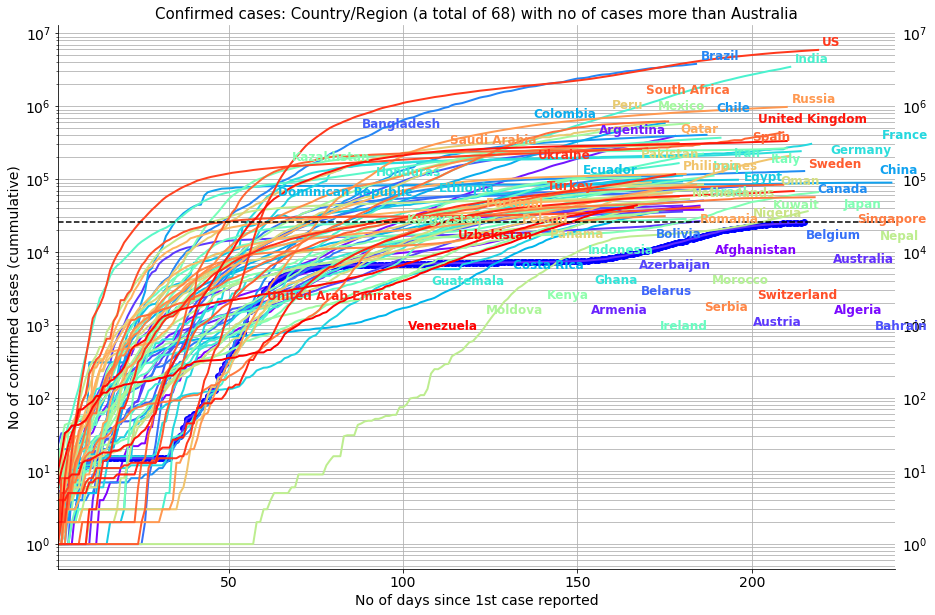

In [3]:
# ## Visualising time series data for sub dataframe - no of cases more than Australia

no_plots = len(gr_confirmed_sub1.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Confirmed cases: Country/Region (a total of %i) with no of cases more than Australia"%(no_plots-1), fontsize=15, )
plt.xlabel("No of days since 1st case reported", fontsize=14)
plt.ylabel("No of confirmed cases (cummulative)", fontsize=14)

xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_confirmed_sub1.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_confirmed_sub1.iloc[i]).to_numpy().nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_confirmed_sub1.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_confirmed_sub1.iloc[i]))
       ypos.append(gr_confirmed_sub1.iloc[i][len(gr_confirmed_sub1.iloc[i])-1])
    
    if gr_confirmed_sub1.index[i] == "Australia":
       plt.plot(days, gr_confirmed_sub1.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_confirmed_sub1.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_confirmed_sub1.index[i], color=colors[i], fontsize=12,\
                  alpha=1,fontweight='bold') for i in range(no_plots)]
adjust_text(texts)
plt.axhline(gr_confirmed_sub.loc["Australia"].max(), color ='black', linestyle='--')
plt.yscale("log")
plt.tick_params(labelright=True, labelsize=14)
plt.grid(which="both")
plt.xlim(1,len(days))

plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_confirmed_sub1.jpg')
plt.show()

In [7]:
## The following dataset is sourced from https://data.humdata.org/dataset that contains 
## measures imposed by government to control spread of infection 

#url_measure = "http://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/c3710749-f552-455d-a9ec-5d9fe974be75/download/acaps_covid19_government_measures_dataset.xlsx"
measure_df = pd.read_excel("C:/Users/das_g/Desktop/Gitua/COVID-19/acaps_covid19_government_measures_dataset.xlsx", sheet_name="Database", index_col="COUNTRY")
#measure_df = pd.read_excel(url_measure, sheet_name = "Database", index_col="COUNTRY")
measure_df.head()
measure_df = measure_df[["MEASURE","DATE_IMPLEMENTED"]]
measure_df = measure_df[pd.notnull(measure_df["DATE_IMPLEMENTED"])]

# # The following names are changed according to those as recorded in confirmed data  
measure_df.index = measure_df.index.str.replace("United States of America", "US") 
measure_df.index = measure_df.index.str.replace("Korea Republic of", "Korea, South")
measure_df.index = measure_df.index.str.replace("kenya", "Kenya")

## Create a dictionary x that contains pairs of country & corresponding list of measures
## We consider only those countries having confirmed cases more than Australia. Thus the 
## dataframe gr_confirmed_sub1 as obtained before is used and having measure data is available

x = {}
measure_list = []
country_list = [i for i in gr_confirmed_sub1.index if i in measure_df.index ]

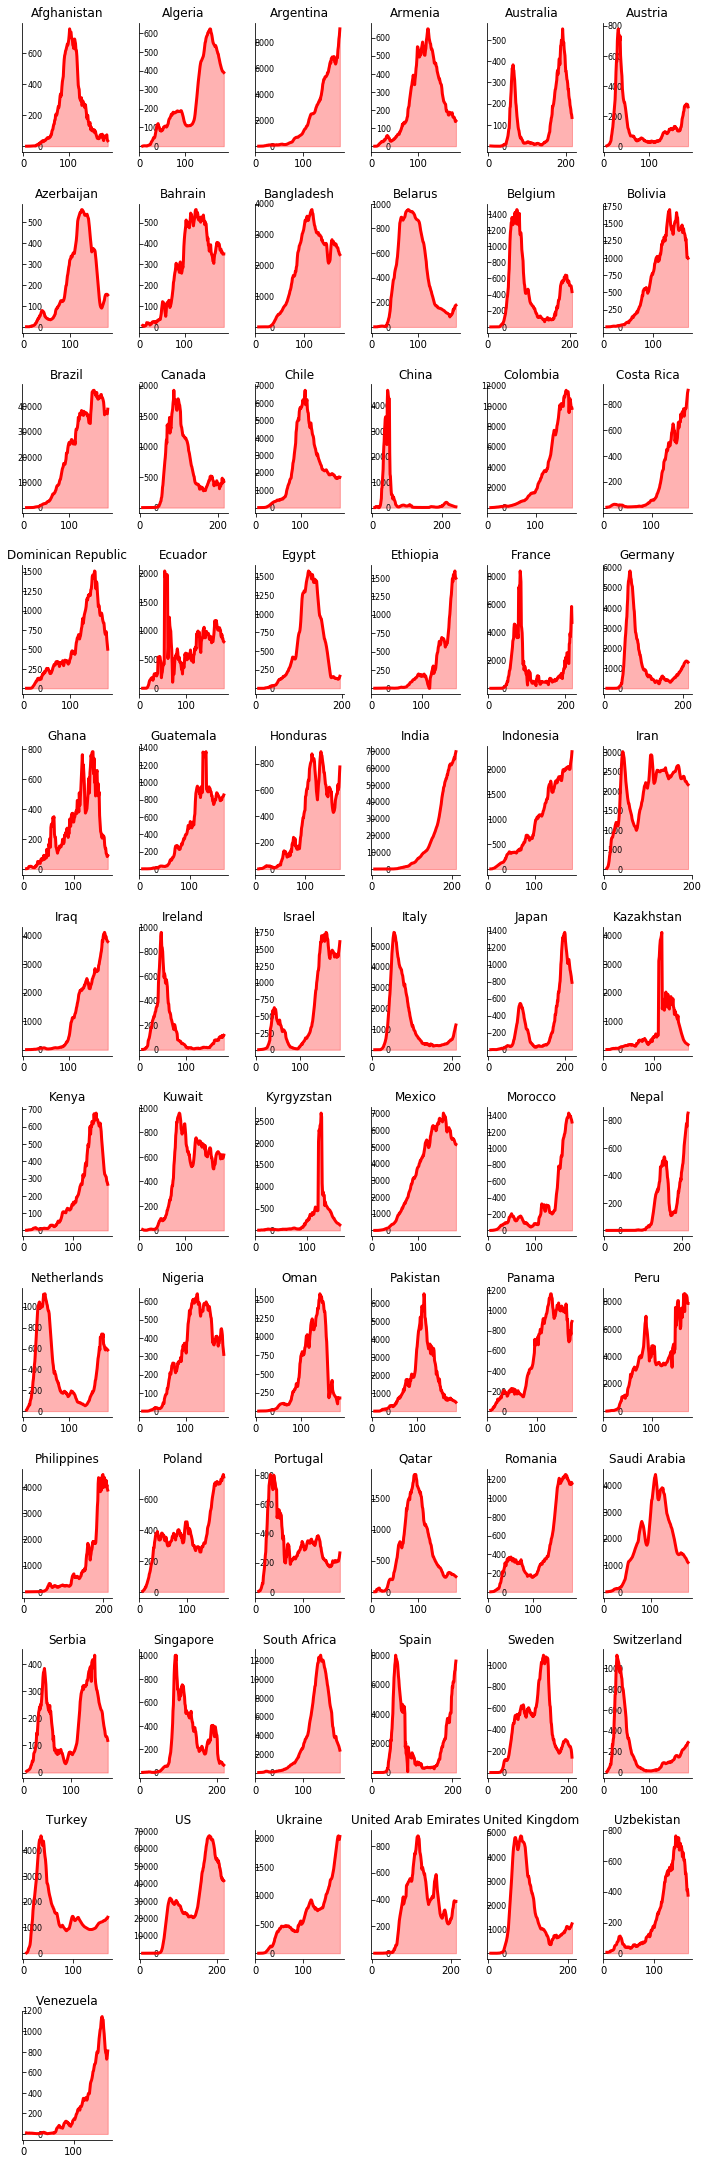

In [8]:
# # Plots of flattening curve for all clusters- 7-day rolling average of daily confirmed cases

gr_confirmed_sub1_daily = gr_confirmed_sub1.diff(axis=1) # obtain from cummulative data
daily = gr_confirmed_sub1_daily.copy()

for country in daily.index:
    if country not in country_list:
        daily.drop([country], inplace=True)

daily.loc["Ecuador"] = daily.loc["Ecuador"].clip(lower=0)
daily_rolling_7 = daily.rolling(window=7, axis=1).mean()
daily_rolling_7.columns = days

# Find the positions and values of max cases and those at today.
# Also, find the rate of percentage decrease from peak value to current value
country_vals = {}

for country in daily_rolling_7.index:
    val_today = daily_rolling_7.loc[country].mask(daily_rolling_7.loc[country]==0).ffill().iloc[-1]
    #daily_rolling_7.loc[country].notna().idxmax() # first valid index
    pos_today = daily_rolling_7.loc[country].notna()[::-1].idxmax() # last valid index (after that all nan)
    val_max = daily_rolling_7.loc[country].max()
    pos_max = daily_rolling_7.loc[country].idxmax(axis=1)
    rate_of_decrease = ((val_max - val_today)/val_max)*100
    #print(country, val_max, '%.2f'%rate_of_decrease)
    country_vals[country] = {"val_max":val_max, "pos_max":pos_max, \
                                 "val_today":val_today, "pos_today":pos_today,"rate":rate_of_decrease}
no_plots = len(daily_rolling_7.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots))
n_cols = 6 # no of columns i.e max no of plots in one row
n_rows = (no_plots // n_cols)+1
Position = range(1, no_plots+1)
fig = plt.figure(figsize=(12,30))

for i, color in enumerate(colors, start=0):    
        p_max = []
        country = daily_rolling_7.index[i]
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.3)
        
        axs = fig.add_subplot(n_rows, n_cols, Position[i])
        axs.plot(days, daily_rolling_7.loc[country], color= "red", linewidth=3)
        axs.fill_between(days, daily_rolling_7.loc[country], color="red", alpha=0.3)
        axs.tick_params(axis="y",direction="in", pad=-20, labelsize=8)
        axs.set_title(country, fontsize=12) 
        pos_max = country_vals[country]["pos_max"]
        p_max.append(country_vals[country]["pos_max"])
        val_max = round(country_vals[country]["val_max"])
        val_today = round(country_vals[country]["val_today"])
        pos_today = round(country_vals[country]["pos_today"])
        rate = round(country_vals[country]["rate"])
        text = "%.0f" %rate + "%"
        #axs.text(pos_max-40, val_max, '({}, {})'.format(pos_max, val_max), color="blue", fontsize=8)
        axs.spines['top'].set_color('none')
        axs.spines['right'].set_color('none')
        #print(country, pos_max, val_max, val_today, pos_today, rate)
#         if rate > 25:
#             axs.plot([pos_max, pos_today], [val_max, val_max], 'b--', lw=1)
#             axs.plot([pos_today, pos_today], [val_max, val_today], 'b--', lw=1)      
#             axs.text(pos_today-10, (val_today+(val_max-val_today)/2), text, fontsize=10, color="blue")

plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Curves.jpg', bbox_inches='tight', dpi=300)          
plt.show()
    


In [9]:
# In the following code we try to find the stage of a country with respect to the shape of the curve of daily cases
# as seen in the previous section. We can see that there are three categories- case1: countries those are yet to reach
# the peak case2: countries have gone past first peak and number of daily cases is lower than peak case3: countries that 
# have gone past the first wave and are now facing the second wave (for ex Australia)
## For measure m_1, we quantify its value using the formula: m_1 = (day_present - day_at_imposed) / day_present
## The earlier a measure is imposed the higher is the value. For case1, day_present is today's day and target value (val)
## is the current number of daily cases. For case 2, we use the today's day and the target value (val) is calculated
## as the reduction (%) of the daily no of cases from peak. For case3 where a country is facing second wave we consider
## day_present as the day it has reached the valley.

daily_rolling_30 = daily.rolling(window=30, axis=1).mean()
daily_rolling_30.columns = days
target_dict = {}

for country in daily_rolling_30.index:
    x = daily_rolling_30.loc[country]

    wave1_flag = False
    phase1_flag = False
    wave2_flag = False

    day_today = x.last_valid_index() 
    val_today = x.loc[x.last_valid_index()] 
    
    peaks, _ = find_peaks(x, prominence=100) # this is to avoid local min 
    #print("peaks: ", peaks)
    #peak1 = x[peaks].max()
    y = -x
    #valleys,_ = find_peaks(y)
    valleys,_ = find_peaks(y, prominence=100)
    #print("valleys:", valleys)

    if len(peaks) != 0:
        if len(valleys) != 0:
            wave2_flag = True
            val = (x[peaks[0]] -abs(y[valleys[0]]))/x[peaks[0]]
            day_valley = valleys[0]
            target_dict[country]=[val, day_valley]
        else:
            wave1_flag = True
            val = (x[peaks[0]] -val_today)/x[peaks[0]]
            target_dict[country] = [val, day_today]        
    else:
        phase1_flag = True
        val = 0
        target_dict[country] = [val, day_today]

for key, val in target_dict.items():
    print(key, val)   

Afghanistan [0.9160420544292972, 186]
Algeria [0, 185]
Argentina [0, 178]
Armenia [0.6717857142857143, 180]
Australia [0.951417004048583, 140]
Austria [0.9337973933649288, 118]
Azerbaijan [0.698494052138699, 180]
Bahrain [0.31852879944483, 186]
Bangladesh [0.28144173995126137, 173]
Belarus [0.8616402212021542, 182]
Belgium [0.9300741945319646, 161]
Bolivia [0.1079417734226664, 170]
Brazil [0.006654855760852901, 116]
Canada [0.8008738438922803, 168]
Chile [0.6835727997207841, 187]
China [0.9978260300165013, 148]
Colombia [0.02615982351585382, 169]
Costa Rica [0, 175]
Dominican Republic [0.28627265811494984, 180]
Ecuador [0.5707347972972973, 94]
Egypt [0.888655462184874, 196]
Ethiopia [0, 168]
France [0.8796899771005812, 124]
Germany [0.9104207019446812, 146]
Ghana [0.5335275423728814, 167]
Guatemala [0.18089753130358818, 167]
Honduras [0.2326260630530024, 170]
India [0, 211]
Indonesia [0, 179]
Iran [0.3812773098600469, 83]
Iraq [0, 186]
Ireland [0.848383757045899, 181]
Israel [0.9284924

In [11]:
## A measure dataset is prepared using all the imposed measures for each country 
for i in range(len(country_list)):
    y = measure_df.loc[country_list[i], "MEASURE"]    
    
    if isinstance(y, str) != True:        
        y = y.unique()
        y = [y[i].rstrip() for i in range(len(y)) ]        
        x[country_list[i]] = y            
    else:
        x[country_list[i]] = y
        
## Create a set consisting of all the measures taken by countries; so any country's set will be a subset of that unique set 
measure_set = set()
for i in range(len(country_list)-1):
    measure_set.update(set(x[country_list[i]]).union(set(x[country_list[i+1]])))   
measure_set = [item for item in measure_set if len(item) > 1] # removes unwanted single-character elements from set
measure_list = list(measure_set)

## The following finds the number of days a measure has been imposed wrt to the date of first case for that country
days_dict = {}
days_no = {}
for j in range(len(country_list)): 
#gives the first ones as several dates are recorded for one measure
    if isinstance(x[country_list[j]], str) == False :
        a = measure_df.loc[country_list[j]].drop_duplicates(subset="MEASURE", keep='first')
        a["MEASURE"] = a["MEASURE"].str.rstrip()
        days_no = {a.iloc[i]['MEASURE']: ((a.iloc[i]['DATE_IMPLEMENTED']).strftime(FMT)) for i in range(len(x[country_list[j]]))}
        days_dict[country_list[j]] = days_no
         
# The following code converts calculates the number of days (w.r.t date of 1st case) a measure is applied
for c_id, c_info in days_dict.items():
    for key in c_info.copy(): # key indicates to a measure applied for a country indicated by c_id         
        c_info[key] = (datetime.strptime(c_info[key], FMT) - datetime.strptime(date_1st_case[c_id], FMT)).days
#         if c_id == 'Australia':
#             print(c_id, key, c_info[key], target_dict[c_id][1])
#if a measure is applied beyond the day we consider for a country, we simply delete that measure
        if c_info[key] > target_dict[c_id][1]: 
            del days_dict[c_id][key]
        

new_days_dict = {}
new_data = []
## If any measure is absent i.e not used for a country we set a value of nan
for j in range(len(country_list)):
    new_days = {}    
    for i in measure_list:        
        if i not in days_dict[country_list[j]]:
            new_days[i] = np.nan  
            new_data.append(np.nan)          
        else:            
            new_days[i] = days_dict[country_list[j]][i]
            new_data.append(days_dict[country_list[j]][i])           
    new_days_dict[country_list[j]] = new_days

## measures_days contains no of days a measure remains applied wrt the day of 1st case
idx = pd.MultiIndex.from_product([country_list, measure_list])
measures_days = pd.DataFrame(data=new_data, index=idx, columns=['Measures Days'])
idx.set_names(['Country', 'Measures'], inplace=True) 
measures_days = measures_days.reset_index()
measures_days = measures_days.pivot(index="Country", columns="Measures", values= "Measures Days")
## Duplication in measures - starting letter is both uppercase and small case
# measures_days.drop(["curfews", "testing policy", "limit public gatherings",\
#                     "strengthening the public health system", "awareness campaigns",\
#                     "full lockdown"], axis=1, inplace=True)     
measures_days.drop(["curfews", \
                    "strengthening the public health system", "awareness campaigns",\
                    "full lockdown", ], axis=1, inplace=True)  

#'requirement to wear protective gear in public'"testing policy", "limit public gatherings",


In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)
measures_days.loc["Australia"]

Measures
Additional health/documents requirements upon arrival            NaN
Amendments to funeral and burial regulations                     NaN
Awareness campaigns                                             51.0
Border checks                                                    NaN
Border closure                                                  54.0
Changes in prison-related policies                              54.0
Checkpoints within the country                                   NaN
Closure of businesses and public services                       56.0
Curfews                                                          NaN
Domestic travel restrictions                                    56.0
Economic measures                                               35.0
Emergency administrative structures activated or established    22.0
Full lockdown                                                    NaN
General recommendations                                         56.0
Health screenings in airp

In [14]:
## All absent/missing values with nan are now replaced by a very small no (close to 0)
## measures_2 is obtained from measures_days after converting the days no into a weight value,
## and then all values are scaled (0,1).

measures_1 = measures_days.copy()
for key, val in target_dict.items():
    #print(key, val[1])
    measures_1.loc[key] = measures_1.loc[key].apply(lambda x: (val[1]-x)/val[1])

# # # Adding target variables to the measures_days dataframe
df = pd.DataFrame.from_dict(target_dict).transpose()
df.columns = ["TargetVal", "Day"]
measures_2 = pd.concat([measures_1, df["TargetVal"]], axis=1)
measures_2 = measures_2.replace(np.nan, 0.00001)

# # All values are now scaled from 0 to 1 range
measures_2[measures_2.columns] = preprocessing.MinMaxScaler().fit_transform(measures_2[measures_2.columns]) # mean =0 & std=1
# measures_days.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/measures_days.csv", mode='a', header=True)
# measures_1.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/measures_days.csv", mode='a', header=True)
# measures_2.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/measures_days.csv", mode='a', header=True)
measures_2

,Additional health/documents requirements upon arrival,Amendments to funeral and burial regulations,Awareness campaigns,Border checks,Border closure,Changes in prison-related policies,Checkpoints within the country,Closure of businesses and public services,Curfews,Domestic travel restrictions,Economic measures,Emergency administrative structures activated or established,Full lockdown,General recommendations,Health screenings in airports and border crossings,Humanitarian exemptions,International flights suspension,Isolation and quarantine policies,Limit product imports/exports,Limit public gatherings,Lockdown of refugee/idp camps or other minorities,Mass population testing,Military deployment,Other public health measures enforced,Partial lockdown,Psychological assistance and medical social work,Requirement to wear protective gear in public,Schools closure,State of emergency declared,Strengthening the public health system,Surveillance and monitoring,Testing policy,Visa restrictions,TargetVal
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.000000,0.842310,0.810738,0.950450,0.879764,0.000000,0.000000,0.000000,1.000000,0.000000,0.851612,0.000000,0.781248,0.714638,0.000000,0.843141,0.851612,0.967742,0.867301,0.000000,0.000000,0.000000,0.935423,0.669352,0.000000,0.000000,0.967742,1.000000,0.764975,0.788308,0.000000,0.000000,0.918038
Algeria,0.000000,0.000000,0.752766,0.659115,0.842560,0.000000,0.864405,0.875512,0.879933,0.859458,0.000000,0.000000,0.885685,0.000000,0.000000,0.000000,0.637753,0.704863,0.000010,0.871989,0.000000,0.000000,0.902396,0.000000,0.637782,0.000000,0.614358,0.913513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Argentina,0.000000,0.000000,0.857940,0.000000,0.827638,0.000000,0.000000,0.932550,0.000000,0.910111,0.936933,0.000000,0.000000,0.658354,0.000000,0.000000,0.695769,0.759549,0.000010,0.906281,0.000000,0.721373,0.000000,0.262365,0.740580,0.000000,0.847594,0.926966,0.910111,0.723861,0.652298,0.623683,0.777152,0.000000
Armenia,0.000000,0.000000,0.923139,0.000000,0.982132,0.000000,0.714105,0.754516,0.000000,0.872221,0.842292,0.000000,0.000000,0.000000,0.637760,0.000000,0.643254,0.746665,0.000010,0.874999,0.000000,0.000000,0.428505,0.000000,0.709747,0.000000,0.569957,0.994444,0.916666,0.000000,0.000000,0.225158,0.768517,0.673249
Australia,0.000000,0.000000,0.503013,0.000000,0.583844,0.670126,0.000000,0.603610,0.000000,0.599996,0.758062,0.674283,0.000000,0.468746,0.000000,0.000000,0.423987,0.599997,0.000010,0.634087,0.000000,0.000000,0.467919,0.313958,0.447545,0.674996,0.000000,0.599996,0.449994,0.530745,0.414673,0.509764,0.610291,0.953490
Austria,0.724903,0.450818,0.583385,0.629798,0.829629,0.000000,0.000000,0.835510,0.000000,0.855931,0.856569,0.644065,0.000000,0.410483,0.000000,0.000000,0.645877,0.657624,0.000010,0.792756,0.657688,0.000000,0.438753,0.644112,0.675803,0.959039,0.707476,0.830507,0.008465,0.622999,0.422602,0.567472,0.675803,0.935832
Azerbaijan,0.000000,0.160610,0.756093,0.000000,0.955730,0.872726,0.000000,0.665090,0.000000,0.372216,0.909677,0.617775,0.904526,0.000000,0.671326,0.000000,0.317552,0.799998,0.000010,0.885605,0.000000,0.000000,0.000000,0.127177,0.754954,0.000000,0.620248,1.000000,0.000000,0.623595,0.000000,0.000000,0.813724,0.700016
Bahrain,0.000000,0.000000,0.518996,0.000000,0.889130,0.991202,0.000000,0.897848,0.858584,0.000000,0.749911,0.000000,0.000000,0.273012,0.649671,0.000000,0.642204,0.774192,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.762469,0.989247,0.000000,0.577979,0.580225,0.682124,0.787475,0.319223
Bangladesh,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.520682,0.517545,0.833770,0.624274,0.654357,0.698263,0.000000,0.000000,0.671326,0.000000,0.698934,0.799998,0.000010,0.491062,0.000000,0.000000,0.928345,0.000000,0.714947,0.000000,0.517437,0.514446,0.000000,0.000000,0.000000,0.000000,0.776095,0.282055


In [18]:
# split dataset into X and y. X is the input data & y is the target variable
X = measures_2.iloc[:,:-1]
y = measures_2['TargetVal']

# Create train and test data using train_test_split. test_size=0.2 means 20% of samples used for test
# random_state is assigned for reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear regression & Lasso model i.e Linear Regression with L1-regularisation to reduce/control
## over-fitting (is indicated by prediction error in test data > error in train data)
linearR_model = LinearRegression().fit(X_train, y_train)
#print(linearR_model) # shows all the default parameter values of the model

# Prediction on train data & compute rmse 
y_pred_train = linearR_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("MAE-train: %.2f" % mae) 

# Prediction on test & compute rmse 
y_pred_test = linearR_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE-test: %.2f" % mae)

# Since RMSE-test is much larger than RMSE-train this indicates over-fitting. A small size
# dataset is prone to over-fitting problem. We will use Lasso model (L1-regularization)
# to reduce overfitting and help in feature selection.
# The following code uses different alpha values to find the one that is suitable for our dataset. 
# Please note that a high value of alpha may lead to all feature coefficients to be zero.

names = X.columns
    
# Create a function called lasso,
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = names
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso_model = lasso.fit(X_train, y_train)
        
        print("Alpha: ", alpha, end=" ")
        # Prediction on train data & compute rmse 
        y_pred_train = lasso_model.predict(X_train)
        mae = mean_absolute_error(y_train, y_pred_train)
        print("MAE-train: %.2f" % mae, end=" ")
        
        # Prediction on test & compute rmse 
        y_pred_test = lasso_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        print("MAE-test: %.2f" % mae)
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        
    # Return the datafram    
    return df  

# Run the function called, Lasso
lasso([.0001, 0.001, 0.005, 0.008, 0.01,0.02, 0.05, 0.08 ])

MAE-train: 0.17
MAE-test: 0.42
Alpha:  0.0001 MAE-train: 0.17 MAE-test: 0.42
Alpha:  0.001 MAE-train: 0.17 MAE-test: 0.40
Alpha:  0.005 MAE-train: 0.20 MAE-test: 0.38
Alpha:  0.008 MAE-train: 0.22 MAE-test: 0.37
Alpha:  0.01 MAE-train: 0.23 MAE-test: 0.37
Alpha:  0.02 MAE-train: 0.27 MAE-test: 0.38
Alpha:  0.05 MAE-train: 0.32 MAE-test: 0.41
Alpha:  0.08 MAE-train: 0.32 MAE-test: 0.41


,Feature Name,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.005000,Alpha = 0.008000,Alpha = 0.010000,Alpha = 0.020000,Alpha = 0.050000,Alpha = 0.080000
0,Additional health/documents requirements upon ...,0.231853,0.188519,0.065325,0.000000,0.000000,0.000000,0.0,0.0
1,Amendments to funeral and burial regulations,-0.005966,-0.000437,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0
2,Awareness campaigns,0.083035,0.066507,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,Border checks,-0.087224,-0.048052,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0
4,Border closure,-0.142924,-0.118166,-0.042159,-0.011920,-0.000000,-0.000000,-0.0,-0.0
5,Changes in prison-related policies,0.011900,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0
6,Checkpoints within the country,0.067360,0.023831,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0
7,Closure of businesses and public services,0.161350,0.096510,0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0
8,Curfews,-0.000000,-0.004529,-0.049457,-0.050121,-0.057131,-0.093078,-0.0,-0.0
9,Domestic travel restrictions,-0.114481,-0.096205,-0.040229,-0.022334,-0.024692,-0.013782,-0.0,-0.0


MAE-train: 0.20
MAE-test: 0.38


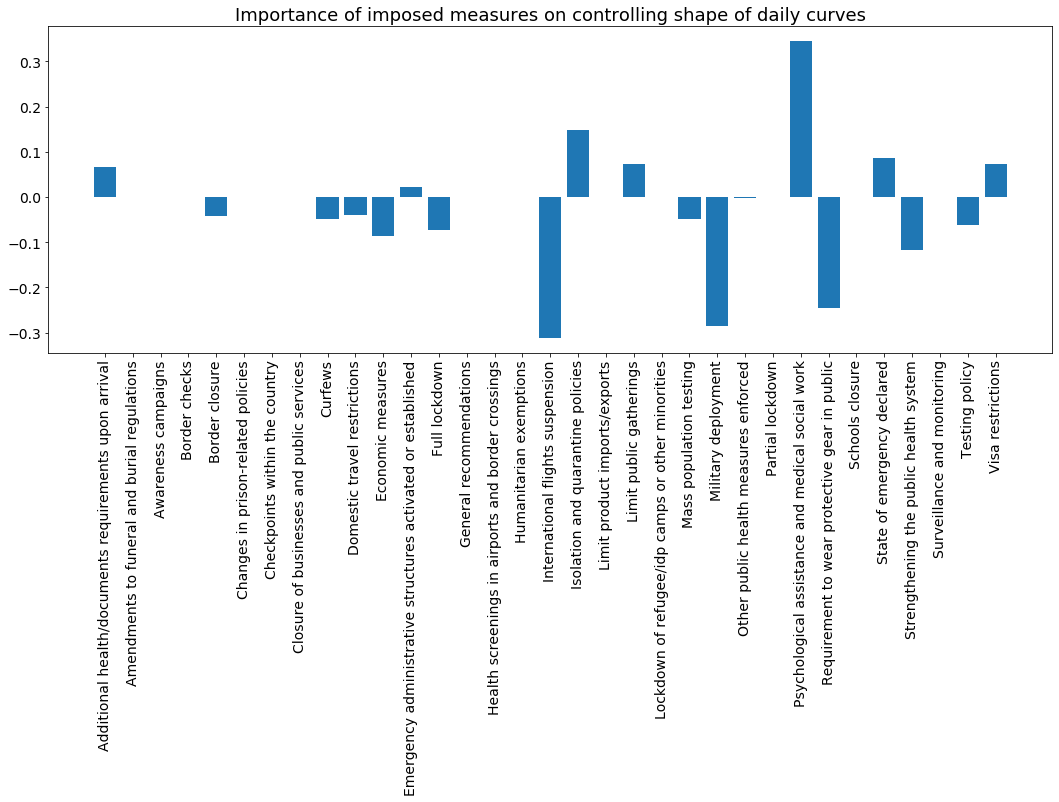

In [19]:
lasso_model = Lasso(alpha=0.005).fit(X_train, y_train)
#print(linearR_model) # shows all the default parameter values of the model

# Prediction on train data & compute rmse 
y_pred_train = lasso_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("MAE-train: %.2f" % mae) 

# Prediction on test & compute rmse 
y_pred_test = lasso_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE-test: %.2f" % mae)

# Plot features with relative importance
importance = lasso_model.coef_

fig = plt.figure(figsize=(18,6))
plt.title("Importance of imposed measures on controlling shape of daily curves", fontsize=18, )
positions = range(33)
labels = measures_2.columns
plt.xticks(positions, labels, rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.bar([x for x in range(len(importance))], importance)
plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Lasso_FeatureImp.jpg', bbox_inches='tight')
plt.show()

In [20]:
### I have followed the following article to hypertune parmeters of the XGBoost model
### "Hyperparameter tuning in XGBoost" by Kevin Lemagnen at Cambridge Spark
### https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

# Convert the dataset into an optimised data structure called Dmatrix that XGBoost supports
# and gives its high performance & efficiency gains

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Bulding a Baseline Model with XGBoost Regression

# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MSE is {:.2f}".format(mae_baseline))

# # # # objective: determines the loss fn to be used, for ex, reg:sqaurederror is for regression
# # # # n_estimators: no of trees, colsample_bytree: percentage of features per tree,
# # # ## high value can lead to overfitting
# # # # model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.005, learning_rate = 0.1,
# # # #                 max_depth = 5, alpha = 10, n_estimators = 5)
# # xgbr = xgb.XGBRegressor(objective ='reg:squarederror')

xgbr_base = xgb.XGBRegressor(objective ='reg:squarederror').fit(X_train, y_train)
#print(model) # shows all the default parameter values of the model

# Prediction on train data & compute rmse 
y_pred_train = xgbr_base.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("MSE-train: %.2f" % mae) 

# Prediction on test & compute mae 
y_pred_test = xgbr_base.predict(X_test)
mae = mean_squared_error(y_test, y_pred_test)
print("MAE-test: %.2f" % mae)

# plt.rcParams["figure.figsize"] = (10, 10)
# #plt.title("Feature importance: XGBoost model's default parameters", fontsize=18, )
# plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Xgbr_base_FeatureImp.jpg', bbox_inches='tight')
# xgb.plot_importance(xgbr_base)
# plt.show()


Baseline MSE is 0.41
MSE-train: 0.00
MAE-test: 0.23


In [21]:
### Training and tuning XBBoost Regressor
## Most of the parameters passed to XGBoost via the native API are defined in a dictionary
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
params['eval_metric'] = "mae"
num_boost_round = 100

model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtest, "Test")],
    early_stopping_rounds = 10
)
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[0]	Test-mae:0.402308
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.405161
[2]	Test-mae:0.403223
[3]	Test-mae:0.415262
[4]	Test-mae:0.410127
[5]	Test-mae:0.407713
[6]	Test-mae:0.403077
[7]	Test-mae:0.401401
[8]	Test-mae:0.403253
[9]	Test-mae:0.40186
[10]	Test-mae:0.400222
[11]	Test-mae:0.399329
[12]	Test-mae:0.400396
[13]	Test-mae:0.399551
[14]	Test-mae:0.399223
[15]	Test-mae:0.399157
[16]	Test-mae:0.398796
[17]	Test-mae:0.398306
[18]	Test-mae:0.398178
[19]	Test-mae:0.398136
[20]	Test-mae:0.398364
[21]	Test-mae:0.398433
[22]	Test-mae:0.39854
[23]	Test-mae:0.398626
[24]	Test-mae:0.398524
[25]	Test-mae:0.398491
[26]	Test-mae:0.398486
[27]	Test-mae:0.398425
[28]	Test-mae:0.398377
[29]	Test-mae:0.398356
Stopping. Best iteration:
[19]	Test-mae:0.398136

Best MAE: 0.40 with 20 rounds


In [22]:
## Training and tuning our XGBoost model using CV
## Cross-validation function is splitting the train dataset into nfolds & iteratively
## keeps one of the folds for test. Check performance with the above params

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    seed = 42,
    nfold = 3, # Can play with this no...2,3,4,5..that gives best reults i.e lowest mae
    metrics = {'mae'},
    early_stopping_rounds = 10
)
print(cv_results) # the no of rows represents the no of boosting trees used
cv_results['test-mae-mean'].min() # best mae score

    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0         0.237068       0.017791       0.300595      0.040515
1         0.179386       0.013374       0.295321      0.032299
2         0.137567       0.009237       0.300230      0.024605
3         0.105331       0.006622       0.298135      0.013968
4         0.081184       0.004260       0.297886      0.010807
5         0.062704       0.002998       0.297713      0.009664
6         0.048313       0.001946       0.298979      0.011676
7         0.037628       0.001383       0.296572      0.012439
8         0.029190       0.001093       0.295422      0.015976
9         0.022741       0.000626       0.295121      0.018282
10        0.017758       0.000378       0.295811      0.019405
11        0.013831       0.000310       0.295485      0.020647
12        0.010748       0.000204       0.294810      0.021484
13        0.008536       0.000142       0.294080      0.022259
14        0.006793       0.000157       0.293936      0

0.29344833333333337

In [23]:
## First we will tune our parameters to minimize MAE on cross validation 
## max_depth (default=6) & min_child_weight (default=1) should be tuned together so as to make a balance
## between bias (underfitting) and variance (overfitting).
# Higher max_depth & smaller min_child_weight leads to over-fitting

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,10)
    for min_child_weight in range(1,10)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed = 42,
        nfold = 3,
        metrics={'mae'},
        early_stopping_rounds = 10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
	MAE 0.28007333333333334 for 7 rounds
CV with max_depth=1, min_child_weight=2
	MAE 0.28007333333333334 for 7 rounds
CV with max_depth=1, min_child_weight=3
	MAE 0.28007333333333334 for 7 rounds
CV with max_depth=1, min_child_weight=4
	MAE 0.28007333333333334 for 7 rounds
CV with max_depth=1, min_child_weight=5
	MAE 0.285093 for 4 rounds
CV with max_depth=1, min_child_weight=6
	MAE 0.2807583333333334 for 20 rounds
CV with max_depth=1, min_child_weight=7
	MAE 0.2812266666666667 for 15 rounds
CV with max_depth=1, min_child_weight=8
	MAE 0.2789163333333333 for 6 rounds
CV with max_depth=1, min_child_weight=9
	MAE 0.27701766666666666 for 7 rounds
CV with max_depth=2, min_child_weight=1
	MAE 0.28786300000000004 for 4 rounds
CV with max_depth=2, min_child_weight=2
	MAE 0.29431433333333334 for 5 rounds
CV with max_depth=2, min_child_weight=3
	MAE 0.294488 for 2 rounds
CV with max_depth=2, min_child_weight=4
	MAE 0.29253066666666666 for 2 rounds
CV with m

In [24]:
params['max_depth'] = 1
params['min_child_weight'] = 9

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed = 42,
        nfold = 3,
        metrics={'mae'},
        early_stopping_rounds = 10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.27701766666666666 for 7 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.28230133333333335 for 29 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.28516233333333335 for 24 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.28134833333333337 for 10 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.270998 for 6 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.27176333333333336 for 6 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.273483 for 6 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.29698066666666667 for 6 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.29603033333333334 for 11 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.30077266666666663 for 14 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.30155266666666664 for 14 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.3091156666666666 for 3 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.3001483333333333 for 17 rounds
CV with subsample=0.7, colsample=0.9
	MAE 

In [25]:
## The following two parameters are updated from previous session
params['subsample'] = 0.9
params['colsample_bytree'] = 1

## Parameter Eta - controls the learning rate. This relates to the amount of correction made
# at each step. Lower a value better for over-fitting but takes longer to train. Timeing 
## should not matter much for a very small dataset like ours
%time
# This can take some time…
min_mae = float("Inf")
best_params = None

for eta in [0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]:
    print("CV with eta={}".format(eta))
    
    # We update our parameters
    params['eta'] = eta
    
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed = 42,
            nfold = 3,
            metrics=['mae'],
            early_stopping_rounds = 10
            )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.1
Wall time: 0 ns
	MAE 0.291735 for 18 rounds

CV with eta=0.2
Wall time: 0 ns
	MAE 0.29007299999999997 for 7 rounds

CV with eta=0.3
Wall time: 0 ns
	MAE 0.270998 for 6 rounds

CV with eta=0.2
Wall time: 0 ns
	MAE 0.29007299999999997 for 7 rounds

CV with eta=0.1
Wall time: 0 ns
	MAE 0.291735 for 18 rounds

CV with eta=0.05
Wall time: 0 ns
	MAE 0.29179499999999997 for 39 rounds

CV with eta=0.01
Wall time: 0 ns
	MAE 0.2964866666666667 for 97 rounds

CV with eta=0.005
Wall time: 0 ns
	MAE 0.3044963333333333 for 99 rounds

CV with eta=0.001
Wall time: 0 ns
	MAE 0.31227066666666664 for 97 rounds

Best params: 0.3, MAE: 0.270998


In [26]:
# The eta as obtained from the previous session 
params['eta'] = 0.3
# params['lambda'] = 1
# params['alpha'] = 0
print(params)

#xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth= 1, min_child_weight= 5, eta= 0.3, subsample= 1, colsample_bytree= 1).fit(X_train, y_train)

xgbr_model = xgb.XGBRegressor(**params).fit(X_train, y_train)

# ## Now with the above parameters let us train our model & check the performance on test set

# Prediction on train data & compute rmse 
y_pred_train = xgbr_model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("MSE-train: %.2f" % mae) 

# Prediction on test & compute mae 
y_pred_test = xgbr_model.predict(X_test)
mae = mean_squared_error(y_test, y_pred_test)
print("MAE-test: %.2f" % mae)

# xgbr_model.save_model("C:/Users/das_g/Desktop/Gitua/COVID-19/my_model.model")

{'max_depth': 1, 'min_child_weight': 9, 'eta': 0.3, 'subsample': 0.9, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}
MSE-train: 0.14
MAE-test: 0.21


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


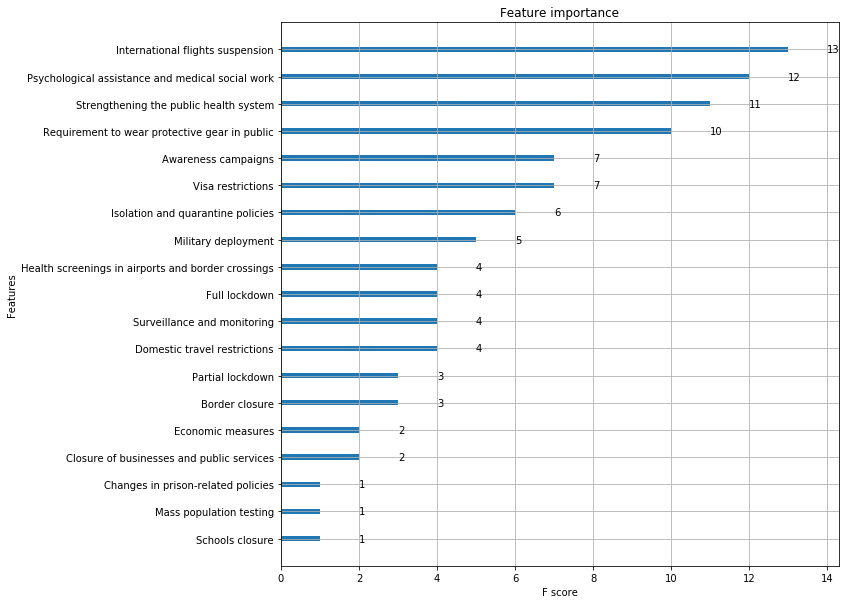

In [27]:
## F score in the feature importance context simply means the number of times a 
## feature is used to split the data across all trees. a
print(xgbr_base)
plt.rcParams["figure.figsize"] = (10, 10)
xgb.plot_importance(xgbr_model)
plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Xgbr_tuned_FeatureImp.jpg', bbox_inches='tight')
plt.show()


MSE-train: 0.19
MAE-test: 0.20


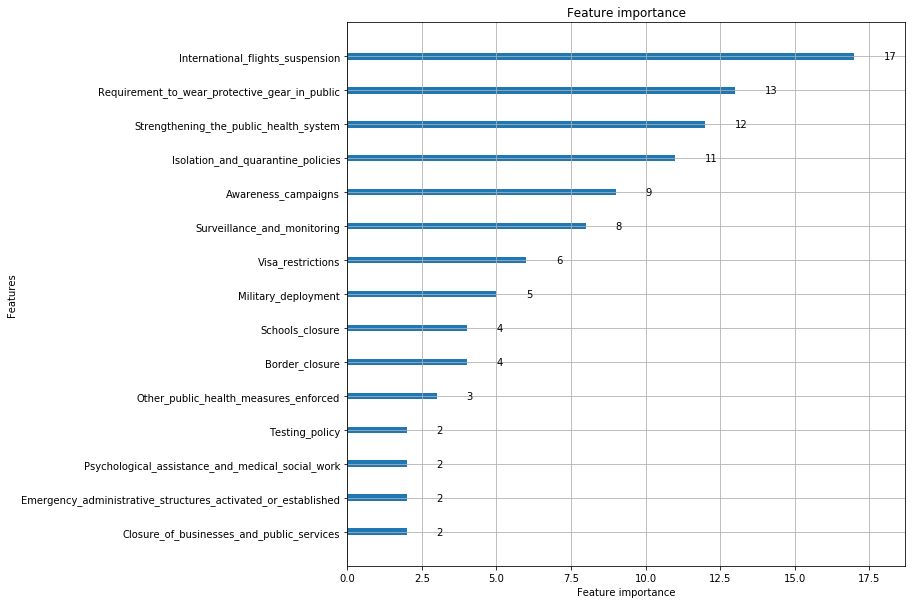

In [28]:
## Light GBM allows leaf-wise tree growth whereas XGBoost allows level-wise
## lgbm is also prone to over-fitting and not suitable for small dataset.
## and max-depth parameter needs to be used carefully, lower the better

# Need to install LightGBM (Light Gradient Bossted Machine) library- "conda install lightgbm"
import lightgbm as lgbm
#print(lightgbm.__version__)

# Convert the dataset into an optimised data structure called Dmatrix that LightGBM supports
# and gives its high performance & efficiency gains

dtrain = lgbm.Dataset(X_train, label=y_train)
dtest = lgbm.Dataset(X_test, label=y_test)

# params = {}
# params['learning_rate'] = 0.003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'regression'
# params['metric'] = 'mse'
# params['sub_feature'] = 0.5
# params['num_leaves'] = 10
# params['min_data'] = 50
# params['max_depth'] = 10

lgbm_base = lgbm.LGBMRegressor()
#print(lgbm_model)
lgbm_base.fit(X_train, y_train)

# Prediction on train data & compute rmse 
y_pred_train = lgbm_base.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("MSE-train: %.2f" % mae) 

# Prediction on test & compute mae 
y_pred_test = lgbm_base.predict(X_test)
mae = mean_squared_error(y_test, y_pred_test)
print("MAE-test: %.2f" % mae)

plt.rcParams["figure.figsize"] = (10, 10)
lgbm.plot_importance(lgbm_base)
plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Lgbm_base_FeatureImp.jpg', bbox_inches='tight')
plt.show()

In [29]:
xgbr_feat = xgbr_model.get_booster().get_score(importance_type='weight')
lgbm_feat = lgbm_base.booster_.feature_importance()

avg_dict = {}
for i in range(len(measures_2.columns)-1):
    if measures_2.columns[i] in xgbr_feat.keys():
        if lgbm_feat[i] != 0:
            val = (lgbm_feat[i] + xgbr_feat.get(measures_2.columns[i]))/2
            avg_dict[measures_2.columns[i]] = val
            
        else:
            avg_dict[measures_2.columns[i]] = float(xgbr_feat.get(measures_2.columns[i]))
    else:   
        avg_dict[measures_2.columns[i]] = float(lgbm_feat[i])  
    print(i, measures_2.columns[i],avg_dict[measures_2.columns[i]] )    
        

0 Additional health/documents requirements upon arrival 0.0
1 Amendments to funeral and burial regulations 0.0
2 Awareness campaigns 8.0
3 Border checks 0.0
4 Border closure 3.5
5 Changes in prison-related policies 1.0
6 Checkpoints within the country 0.0
7 Closure of businesses and public services 2.0
8 Curfews 0.0
9 Domestic travel restrictions 4.0
10 Economic measures 2.0
11 Emergency administrative structures activated or established 2.0
12 Full lockdown 4.0
13 General recommendations 0.0
14 Health screenings in airports and border crossings 4.0
15 Humanitarian exemptions 0.0
16 International flights suspension 15.0
17 Isolation and quarantine policies 8.5
18 Limit product imports/exports 0.0
19 Limit public gatherings 0.0
20 Lockdown of refugee/idp camps or other minorities 0.0
21 Mass population testing 1.0
22 Military deployment 5.0
23 Other public health measures enforced 3.0
24 Partial lockdown 3.0
25 Psychological assistance and medical social work 7.0
26 Requirement to wear 

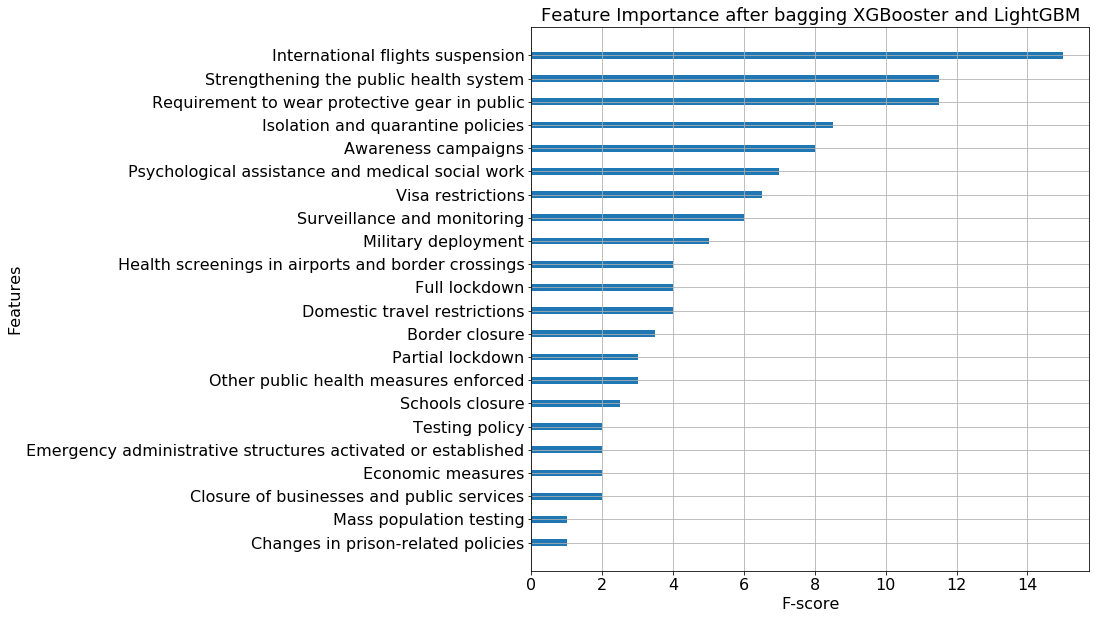

In [57]:
avg_dict = {x:y for x,y in avg_dict.items() if y!=0} # Removes values with zero
a = sorted(avg_dict.items(), key=lambda x: x[1], reverse=False) # Sort in ascending order
#a = np.array(a)

plt.figure(figsize=(10,10))

plt.title("Feature Importance after bagging XGBooster and LightGBM", fontsize=18)
plt.xlabel("F-score", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(which="both")

#plt.barh(a[:,0],a[:,1], height=.3)
plt.barh([i[0] for i in a], [i[1] for i in a], height=0.3)
plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/FeatureImpBagged.jpg', bbox_inches='tight')
plt.show()